In [176]:
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.utils import check_random_state

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer

from ISLP import load_data



In [3]:
SEED_VALUE = 0
np.random.seed(SEED_VALUE)
rng = check_random_state(SEED_VALUE)

In [5]:
data = load_data('Credit')

data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [7]:
data.Ethnicity.unique()

array(['Caucasian', 'Asian', 'African American'], dtype=object)

In [48]:
scaler = StandardScaler()
one_hot_encoder = OneHotEncoder(sparse_output=False)
label_binarizer = LabelBinarizer()

In [49]:
preds_numeric = data.loc[:, ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education']]
preds_cat = data.loc[:, ['Gender', 'Student', 'Married', 'Ethnicity']]
y_response = data.iloc[:, -1]

In [50]:
for column in preds_cat.columns[:-1]:
    data[f'bin_{column}'] = label_binarizer.fit_transform(data[column])

In [71]:
data['Ethnicity'].unique()

array(['Caucasian', 'Asian', 'African American'], dtype=object)

In [72]:
dummy_ethnicity = pd.get_dummies(data['Ethnicity'], prefix='Ethnicity', drop_first=True)

df = pd.concat([data, dummy_ethnicity], axis=1)

In [85]:
df['Ethnicity_Asian'] = label_binarizer.fit_transform(df['Ethnicity_Asian'])

In [86]:
df['Ethnicity_Caucasian'] = label_binarizer.fit_transform(df['Ethnicity_Caucasian'])

In [87]:
predictors = df.loc[:, ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Balance', 'bin_Gender', 'bin_Student', 'bin_Married', 'Ethnicity_Asian', 'Ethnicity_Caucasian']]

In [172]:
predictors

,Income,Limit,Rating,Cards,Age,Education,Balance,bin_Gender,bin_Student,bin_Married,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,11,333,0,0,1,0,1
1,106.025,6645,483,3,82,15,903,1,1,1,1,0
2,104.593,7075,514,4,71,11,580,0,0,0,1,0
3,148.924,9504,681,3,36,11,964,1,0,0,1,0
4,55.882,4897,357,2,68,16,331,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,560,0,0,1,0,1
396,13.364,3838,296,5,65,17,480,0,0,0,0,0
397,57.872,4171,321,5,67,12,138,1,0,1,0,1
398,37.728,2525,192,1,44,13,0,0,0,1,0,1


In [88]:
X_train, X_test, y_train, y_test = train_test_split(predictors, y_response, test_size=.2, random_state=rng, shuffle=True)

In [92]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

### Best Subset Selection method 


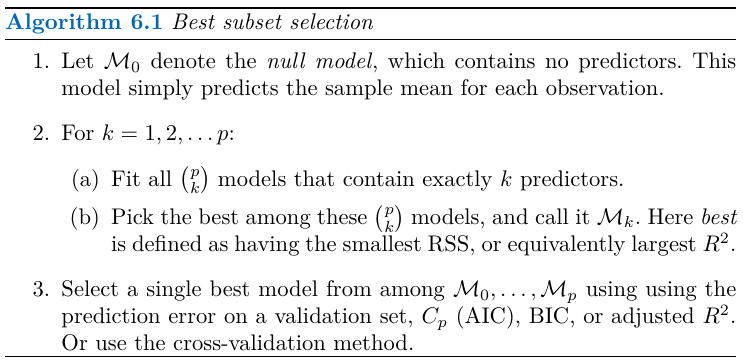

In [311]:
from itertools import combinations
from sklearn.metrics import r2_score, mean_squared_error

def null_model(X, y):
    y_hat_mean = np.mean(y)
    return np.full(len(X), y_hat_mean)


def calculate_AIC(X_test, y_test, y_pred):
    n = len(X_test)
    p = X_test.shape[1] + 1
    sse = ( (y_test - y_pred) ** 2 ).sum() + 1e-10
    AIC = n * np.log(sse / n) + 2 * p
    return AIC


def calculate_BIC(X_test, y_test, y_pred):
    n = len(X_test)
    p = X_test.shape[1] + 1
    sse = ( (y_test - y_pred) ** 2 ).sum()
    BIC = (n * np.log(sse / n)) + (p * np.log(n))
    return BIC
    

def calculate_adjR2_score(X_test, y_test, y_pred):
    n = len(y_test)
    p = X_test.shape[1]
    r_squared = r2_score(y_test, y_pred)
    adjusted_r_squared = 1 - (((1 - r_squared) * (n - 1)) / (n - p - 1))
    return adjusted_r_squared


def best_subset_selection(X_train, X_test, y_train, y_test, test_metric='AIC'):
    
    if test_metric not in ['AIC', 'BIC', 'ADJ_R2']:
        raise ValueError(f"Invalid test_metric: {test_metric}")
    
    if test_metric in ['AIC', 'BIC']:
        best_score = float('inf')
    else:
        best_score = -float('inf')
    
    M_k_models = [] # In this list are stored $M_k$ models, those are the best among ${p \choose k}$ models.
    test_metrics = {
        'AIC': calculate_AIC,
        'BIC': calculate_BIC,
        'ADJ_R2': calculate_adjR2_score,
    }
    
    def get_subsets(predictors, k):
        return list(combinations(predictors, k))

    def select_features(data_set, columns_index_combinations):
        return data_set[:, list(columns_index_combinations)]
        
    p = X_train.shape[1]
    # Training models
    for k in range(1, p + 1):
        predictor_combinations = get_subsets(np.arange(p), k)        
        models_k = []
        for index_column in predictor_combinations:
            X_train_features = select_features(X_train, index_column)
            
            linear_model = LinearRegression()
            linear_model.fit(X_train_features, y_train)

            r2_score_train = linear_model.score(X_train_features, y_train)
            
            models_k.append(
                {'model': linear_model, 'train_r2_score': r2_score_train, 'column_combination_index': list(index_column)}
            )

        # Here, we got our $M_k$ model — this is the model with the largest training R^{2} score.
        index_of_max_r2_score = max(range(len(models_k)), key=lambda i: models_k[i]['train_r2_score'])
        M_k_models.append(models_k[index_of_max_r2_score])

    for model_m_k in M_k_models:
        model = model_m_k.get('model')
        test_columns_index = model_m_k.get('column_combination_index')
        X_test_features = select_features(X_test, test_columns_index)
        y_pred = model.predict(X_test_features)
        test_score = test_metrics.get(test_metric)(X_test_features, y_test, y_pred)
        if (test_metric in ['AIC', 'BIC'] and test_score < best_score) or \
           (test_metric == 'ADJ_R2' and test_score > best_score):
            best_score = test_score
            best_model = model
            best_subset_of_features_index = test_columns_index

    return best_subset_of_features_index

best_subset_features_index = best_subset_selection(X_train_std, X_test_std, y_train, y_test, test_metric='BIC')
print(f'BIC: {best_subset_features_index}')
print(predictors.columns[best_subset_features_index])

best_subset_features_index = best_subset_selection(X_train_std, X_test_std, y_train, y_test, test_metric='AIC')
print(f'AIC: {best_subset_features_index}')
print(predictors.columns[best_subset_features_index])

best_subset_features_index = best_subset_selection(X_train_std, X_test_std, y_train, y_test, test_metric='ADJ_R2')
print(f'Adjusted R^2: {best_subset_features_index}') 
print(predictors.columns[best_subset_features_index])

BIC: [0, 1, 2, 9]
Index(['Income', 'Limit', 'Rating', 'bin_Married'], dtype='object')
AIC: [9]
Index(['bin_Married'], dtype='object')
Adjusted R^2: [9]
Index(['bin_Married'], dtype='object')


### Forward Subset Selection method

In [289]:
def forward_subset_selection(X_train, X_test, y_train, y_test, test_metric='AIC'):

    if test_metric not in ['AIC', 'BIC', 'ADJ_R2']:
        raise ValueError(f"Invalid test_metric: {test_metric}")
    
    if test_metric in ['AIC', 'BIC']:
        best_criterion = float('inf')
    else:
        best_criterion = -float('inf')
        
    test_metrics = {
        'AIC': calculate_AIC,
        'BIC': calculate_BIC,
        'ADJ_R2': calculate_adjR2_score,
    }
    
    selected_predictors = []
    best_model = None
    
    # Repeat this unitl no improvement
    while True:
        improvement_found = False

        for predictor_idx in range(X_train.shape[1]):
            if predictor_idx not in selected_predictors:
                predictors_to_include = selected_predictors + [predictor_idx]
                X_train_subset = X_train[:, predictors_to_include]

                # Fitting a model
                model = LinearRegression()
                model.fit(X_train_subset, y_train)

                X_test_subset = X_test[:, predictors_to_include]
                y_pred = model.predict(X_test_subset)

                # Evalutaing model based on the criterion like AIC, BIC, Adjusted R^{2}
                criterion = test_metrics.get(test_metric)(X_test_subset, y_test, y_pred)

                if (test_metric in ['AIC', 'BIC'] and criterion < best_criterion) or \
                    (test_metric == 'ADJ_R2' and criterion > best_criterion):
                    best_model = model
                    best_criterion = criterion
                    best_predictor_idx = predictor_idx
                    improvement_found = True
        
        if improvement_found:
            selected_predictors.append(best_predictor_idx)
        else:
            break


    return selected_predictors

In [312]:
best_subset_features_index = forward_subset_selection(X_train_std, X_test_std, y_train, y_test) # AIC
print(predictors.columns[best_subset_features_index])

Index(['bin_Married'], dtype='object')


In [313]:
best_subset_features_index = forward_subset_selection(X_train_std, X_test_std, y_train, y_test, test_metric='BIC')
print(predictors.columns[best_subset_features_index])

Index(['bin_Married', 'Education', 'Income'], dtype='object')


In [314]:
best_subset_features_index = forward_subset_selection(X_train_std, X_test_std, y_train, y_test, test_metric='ADJ_R2')
print(predictors.columns[best_subset_features_index])

Index(['bin_Married'], dtype='object')


### Backward Stepwise Selection

In [293]:
def backward_stepwise_selection(X_train, X_test, y_train, y_test, test_metric='AIC'):

    if test_metric not in ['AIC', 'BIC', 'ADJ_R2']:
        raise ValueError(f"Invalid test_metric: {test_metric}")

    if X_train.shape[1] > X_train.shape[0]:
        raise ValueError('In backward stepwise selection method, it\'s not possible to perform when p > n')
        
    test_metrics = {
        'AIC': calculate_AIC,
        'BIC': calculate_BIC,
        'ADJ_R2': calculate_adjR2_score,
    }

    num_predictors = X_train.shape[1]
    selected_predictors = list(range(num_predictors))  
    best_model = LinearRegression().fit(X_train, y_train)         
    y_pred = best_model.predict(X_test)
    best_criterion = test_metrics.get(test_metric)(X_test, y_test, y_pred)

    while True:
        improvement_found = False

        for predictor_idx in selected_predictors:
            if len(selected_predictors) == 1:
                break
            predictors_to_exclude = [i for i in selected_predictors if i != predictor_idx]
            X_train_subset = X_train[:, predictors_to_exclude]
            # Fit a model without the predictor
            model = LinearRegression().fit(X_train_subset, y_train)

            X_test_subset = X_test[:, predictors_to_exclude]
            # Evaluate using a criterion 
            y_pred = model.predict(X_test_subset)
            criterion = test_metrics.get(test_metric)(X_test_subset, y_test, y_pred)

            # Check for improvement
            if (test_metric in ['AIC', 'BIC'] and criterion < best_criterion) or \
                (test_metric == 'ADJ_R2' and criterion > best_criterion):
                best_model = model
                best_criterion = criterion
                best_predictors = predictors_to_exclude
                improvement_found = True

        # Step 3: Deletion
        if improvement_found:
            selected_predictors = best_predictors.copy()
        else:
            break

    return selected_predictors


In [306]:
best_predictor_subset = backward_stepwise_selection(X_train_std, X_test_std, y_train, y_test)

predictors.columns[[i for i in best_predictor_subset]]

Index(['bin_Married'], dtype='object')

In [310]:
best_predictor_subset = backward_stepwise_selection(X_train_std, X_test_std, y_train, y_test, test_metric='BIC')
predictors.columns[[i for i in best_predictor_subset]]

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Balance',
       'bin_Student', 'bin_Married', 'Ethnicity_Asian', 'Ethnicity_Caucasian'],
      dtype='object')

In [309]:
best_predictor_subset = backward_stepwise_selection(X_train_std, X_test_std, y_train, y_test, test_metric='ADJ_R2')
predictors.columns[[i for i in best_predictor_subset]]

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Balance',
       'bin_Gender', 'bin_Student', 'bin_Married', 'Ethnicity_Asian',
       'Ethnicity_Caucasian'],
      dtype='object')